导入必要的库

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

定义模型

In [18]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
      

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(64 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.fc(x)
        return x


数据加载和预处理

In [31]:
def get_dataloader(dataset_name, train=True):
 

        # 使用 transforms 将所有图像转为灰度图像
    transform = transforms.Compose([
        transforms.Resize((28, 28)),  # 调整图像大小以适应模型
        transforms.Grayscale(num_output_channels=1),  # 转换为单通道灰度图
        transforms.ToTensor(),  # 转换为tensor
        transforms.Normalize((0.5,), (0.5,))  # 标准化
    ])


    if dataset_name == 'MNIST':
        dataset = torchvision.datasets.MNIST
        data = dataset(root='./data', train=train, download=True, transform=transform)
    elif dataset_name == 'CIFAR10':
        transform.transforms.insert(0, transforms.Grayscale(num_output_channels=1))
        dataset = torchvision.datasets.CIFAR10
        data = dataset(root='./data', train=train, download=True, transform=transform)
    elif dataset_name == 'FashionMNIST':
        dataset = torchvision.datasets.FashionMNIST
        data = dataset(root='./data', train=train, download=True, transform=transform)
    elif dataset_name == 'SVHN':
        
        dataset = torchvision.datasets.SVHN
        data = dataset(root='./data', split='train' if train else 'test', download=True, transform=transform)
    else:
        # 如果没有匹配的数据集名称，返回None或抛出异常
        raise ValueError(f"Unsupported dataset: {dataset_name}")

    dataloader = DataLoader(data, batch_size=64, shuffle=True)
    dataloader.dataset.dataset_name = dataset_name  # 给dataloader添加属性以便打印
    return dataloader


# 训练和评估函数

In [20]:

def finetune_and_evaluate(model, train_loader, test_loader, epochs, optimizer, criterion):
    # 微调模型
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # 测试模型
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on {test_loader.dataset.dataset_name}: {accuracy}%')
    return accuracy


执行预训练和微调

In [32]:

# 主程序
def main():
    datasets = ['MNIST', 'CIFAR10', 'FashionMNIST', 'SVHN']
    results = {}

    for dataset_name in datasets:
        print(f'Starting training and testing on {dataset_name}')
        model = SimpleCNN(num_classes=10 if dataset_name != 'SVHN' else 1).to(device)
        train_loader = get_dataloader(dataset_name, train=True)
        test_loader = get_dataloader(dataset_name, train=False)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        # 微调和评估
        accuracy = finetune_and_evaluate(model, train_loader, test_loader, 5, optimizer, criterion)

        # accuracy = finetune_and_evaluate(model, train_loader, test_loader, epochs=5, optimizer, criterion)
        results[dataset_name] = accuracy

    # 打印所有结果
    print("Final results across datasets:")
    for dataset_name, accuracy in results.items():
        print(f'{dataset_name}: {accuracy}%')

if __name__ == '__main__':
    main()

Starting training and testing on MNIST
Accuracy on MNIST: 99.02%
Starting training and testing on CIFAR10
Files already downloaded and verified
Files already downloaded and verified
Accuracy on CIFAR10: 64.29%
Starting training and testing on FashionMNIST
Accuracy on FashionMNIST: 91.19%
Starting training and testing on SVHN
Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat


../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [0,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [1,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [3,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [5,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [6,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [7,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_f

RuntimeError: CUDA error: CUBLAS_STATUS_EXECUTION_FAILED when calling `cublasSgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`

Using downloaded and verified file: ./data/train_32x32.mat


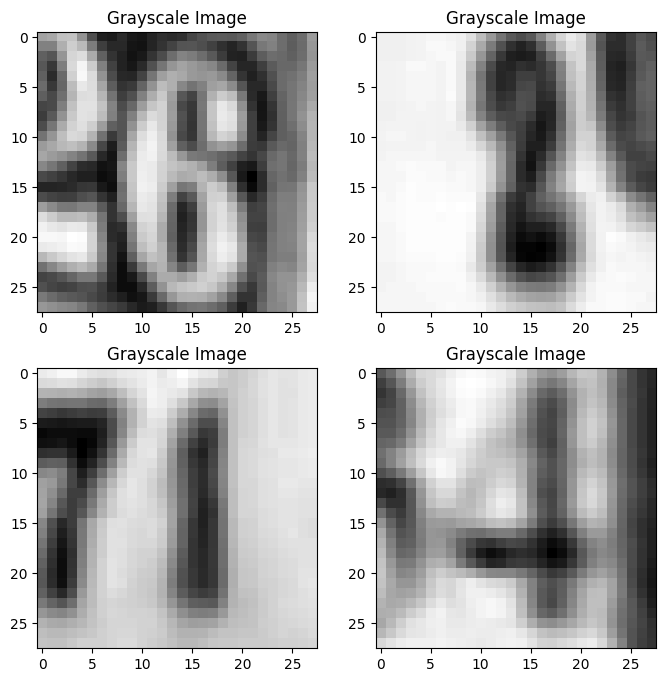

In [30]:
from torchvision.transforms.functional import to_pil_image, to_tensor

def get_dataloader(dataset_name, train=True):
    transform = transforms.Compose([
        transforms.Resize((28, 28)),  # 调整图像大小以适应模型
        transforms.Grayscale(num_output_channels=1),  # 转换为单通道灰度图
        transforms.ToTensor(),  # 转换为Tensor
        transforms.Normalize((0.5,), (0.5,))  # 归一化处理
    ])

    if dataset_name == 'MNIST':
        dataset = torchvision.datasets.MNIST
    elif dataset_name == 'CIFAR10':
        dataset = torchvision.datasets.CIFAR10
    elif dataset_name == 'FashionMNIST':
        dataset = torchvision.datasets.FashionMNIST
    elif dataset_name == 'SVHN':
        dataset = torchvision.datasets.SVHN
        # 特别处理SVHN，确保正确转换为灰度图
        data = dataset(root='./data', split='train' if train else 'test', download=True, transform=transform)
    else:
        data = dataset(root='./data', train=train, download=True, transform=transform)

    dataloader = DataLoader(data, batch_size=64, shuffle=True)
    dataloader.dataset.dataset_name = dataset_name
    return dataloader
 
import matplotlib.pyplot as plt

def show_grayscale_images(dataloader):
    images, _ = next(iter(dataloader))
    plt.figure(figsize=(8, 8))
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title("Grayscale Image")
    plt.show()

# 示例使用SVHN数据集
svhn_loader = get_dataloader('SVHN', train=True)
show_grayscale_images(svhn_loader)


测试模型,lingwai

In [ ]:
def test(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the test images: {100 * correct / total}%')

test_dataloader = get_dataloader('FashionMNIST')
test(model, test_dataloader)


In [26]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)


2.3.0+cu121
True
12.1
